In [31]:
import matplotlib

In [32]:
import os
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader

datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters-complete', '8_19')
num_filters = 8
savepath = 'vae_joint_' + str(num_filters) + '.pt'

In [33]:
def get_joint_dataset():
  weight_dataset = []
  for f, file in tqdm(enumerate(os.listdir(filterpath))):
    filter = torch.load(os.path.join(filterpath, file))
    weight_dataset.append(filter['0.weight'])
  return torch.stack(weight_dataset)

num_images = len(os.listdir(filterpath))
dataset = get_joint_dataset()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

1364it [00:01, 1336.47it/s]


In [34]:
dataset.shape

torch.Size([1364, 8, 1, 5, 5])

In [72]:
vae_batch_size = 100

x_dim  = 25*num_filters
hidden_dim1 = 20*num_filters
hidden_dim2 = 20*num_filters
hidden_dim3 = 20*num_filters
hidden_dim4 = 20*num_filters
latent_dim = 10*num_filters

kl_start = 0
warm_up = 50000

lr = 1e-2

epochs = 500

# kwargs = {'num_workers': 1} 

train_dataset = dataset.to(device)
train_loader = DataLoader(dataset=train_dataset, batch_size=vae_batch_size, shuffle=True)

In [84]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_input4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_mean  = nn.Linear(hidden_dim2, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim2, latent_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

        self.training = True
        
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        h_       = self.tanh(self.FC_input3(h_))
        h_       = self.tanh(self.FC_input4(h_))

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim1)
        self.FC_hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim4)

        self.FC_output = nn.Linear(hidden_dim4, output_dim)
        
        # self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        h     = self.tanh(self.FC_hidden(x))
        h     = self.tanh(self.FC_hidden2(h))
        h     = self.tanh(self.FC_hidden3(h))
        h     = self.tanh(self.FC_hidden4(h))

        x_hat = self.FC_output(h)
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        # self.lamb = nn.Parameter(data=torch.Tensor(1), requires_grad=True)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3, hidden_dim4=hidden_dim4, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)
criterion = torch.nn.MSELoss()

In [85]:
kl_weight = kl_start
anneal_rate = (1.0 - kl_start) / (warm_up * (len(train_dataset) / vae_batch_size))

In [86]:
optimizer = Adam(model.parameters(), lr=lr)

model.train()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=200, out_features=160, bias=True)
    (FC_input2): Linear(in_features=160, out_features=160, bias=True)
    (FC_input3): Linear(in_features=160, out_features=160, bias=True)
    (FC_input4): Linear(in_features=160, out_features=160, bias=True)
    (FC_mean): Linear(in_features=160, out_features=80, bias=True)
    (FC_var): Linear(in_features=160, out_features=80, bias=True)
    (tanh): Tanh()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=80, out_features=160, bias=True)
    (FC_hidden2): Linear(in_features=160, out_features=160, bias=True)
    (FC_hidden3): Linear(in_features=160, out_features=160, bias=True)
    (FC_hidden4): Linear(in_features=160, out_features=160, bias=True)
    (FC_output): Linear(in_features=160, out_features=200, bias=True)
    (tanh): Tanh()
  )
)

In [87]:
reproduction_losses = []
for epoch in range(epochs):
    overall_loss = 0
    reproduction_loss_epoch = 0
    KL_loss_epoch = 0
    for batch_idx, x in enumerate(train_loader):

        model.train()
        x = x.view(x.shape[0], x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        
        kl_weight = min(1.0, kl_weight + anneal_rate)

        reproduction_loss = torch.mean(torch.norm(x_hat - x, dim=1) ** 2)
        KL_loss      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        loss_val = reproduction_loss + kl_weight * KL_loss
        
        overall_loss += loss_val.item()
        reproduction_loss_epoch += reproduction_loss.item()
        KL_loss_epoch += KL_loss.item()
        
        loss_val.backward()
        optimizer.step()

    reproduction_losses.append(reproduction_loss_epoch/(batch_idx*vae_batch_size))
    # print(model.Encoder.FC_mean.grad) 
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", round(overall_loss / (batch_idx*vae_batch_size), 6), 'Reproduction loss', round(reproduction_loss_epoch/ (batch_idx*vae_batch_size), 4), 'KL_loss', round(KL_loss_epoch/ (batch_idx*vae_batch_size), 7), 'kl weight', round(kl_weight, 2))
    
torch.save(model.state_dict(), os.path.join(datapath, savepath))

	Epoch 1 complete! 	Average Loss:  3.339512 Reproduction loss 3.3377 KL_loss 122.8569345 kl weight 0.0
	Epoch 2 complete! 	Average Loss:  2.673764 Reproduction loss 2.662 KL_loss 371.0622025 kl weight 0.0
	Epoch 3 complete! 	Average Loss:  2.376806 Reproduction loss 2.3558 KL_loss 406.2691526 kl weight 0.0
	Epoch 4 complete! 	Average Loss:  2.166266 Reproduction loss 2.1388 KL_loss 379.7553245 kl weight 0.0
	Epoch 5 complete! 	Average Loss:  2.036599 Reproduction loss 1.9976 KL_loss 418.456268 kl weight 0.0
	Epoch 6 complete! 	Average Loss:  1.893845 Reproduction loss 1.8468 KL_loss 415.3578486 kl weight 0.0
	Epoch 7 complete! 	Average Loss:  1.819413 Reproduction loss 1.7684 KL_loss 381.9767443 kl weight 0.0
	Epoch 8 complete! 	Average Loss:  1.791507 Reproduction loss 1.7468 KL_loss 289.949405 kl weight 0.0
	Epoch 9 complete! 	Average Loss:  1.751083 Reproduction loss 1.7021 KL_loss 279.4964213 kl weight 0.0
	Epoch 10 complete! 	Average Loss:  1.707119 Reproduction loss 1.6478 KL_los

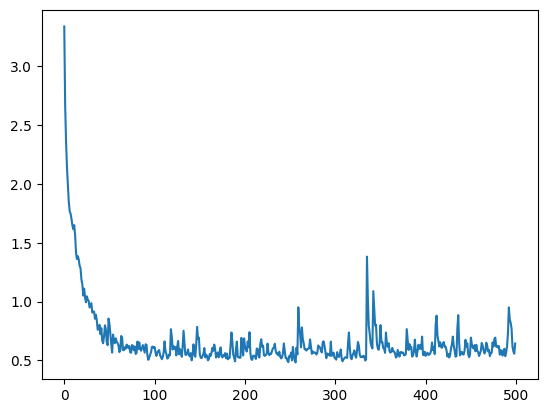

In [89]:
plt.plot(reproduction_losses)


In [90]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)

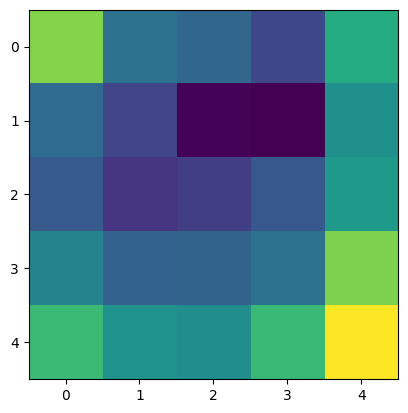

In [91]:
plt.imshow(generated_images[0].view(8, 5, 5).detach().cpu()[0])

In [92]:
vmin, vmax = -2.5, 2.5

In [93]:
def visualise_vae_joint(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, num_filters, figsize=(int(5*(num_filters//8)), num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 8, 5, 5)

  for i in range(num_rows):
    idx = random.choice(range(len(generated_images)))
    for j in range(num_filters):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[idx][j].cpu().numpy(), interpolation=None, norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False))

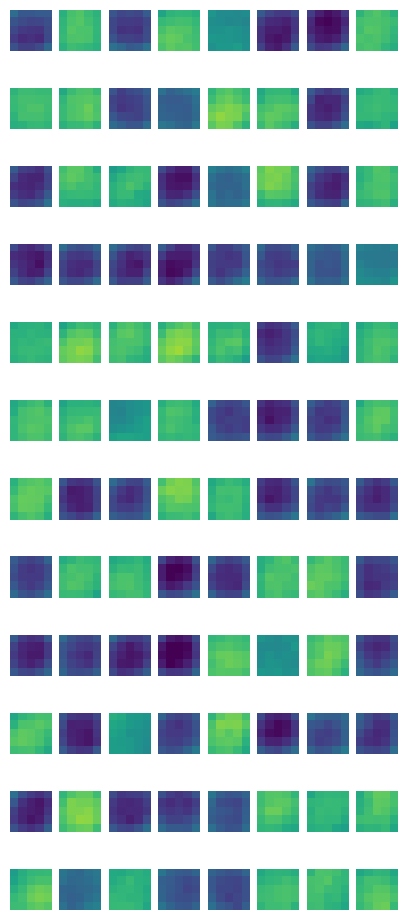

In [94]:
visualise_vae_joint(100//num_filters, generated_images)

In [ ]:
for i in range(len(dataset)):
    print(i, "\n", torch.max(dataset[i]), "\n", torch.min(dataset[i]), "\n\n")

In [155]:
k = 33
print(torch.mean(dataset[100*k:100*(k+1)]))
print(torch.std(dataset[100*k:100*(k+1)]))

tensor(-0.1181, device='cuda:0')
tensor(1.3148, device='cuda:0')


In [136]:
def debug(x):
    for i in range(len(x)):
        print(i, "\n", torch.max(x[i]), "\n", torch.min(x[i]), "\n\n")

In [ ]:
debug(generated_images)